<a href="https://colab.research.google.com/github/fsclsnow/AML/blob/master/AML_Project6_KMean_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6 - Team 2
Joe, Getong, Abby

In this project, the following items were performed.

1) Select 4 datasets

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

5) Train a Gaussian mixture model  on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.


# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import urllib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import IPython.display as display
from PIL import Image

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
import tensorflow_datasets as tfds

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train_2d = X_train.reshape(60000,-1)
X_train_2d.shape
X_test_2d = X_test.reshape(10000,-1)

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_2d)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [30]:
inertias 

[3163502.2,
 2960780.8400971578,
 2816456.49579086,
 2707243.5099163563,
 2605960.4654046213,
 2533295.9175548307,
 2479887.9212119407,
 2432393.929051661,
 2388861.719857866]

Saving figure inertia_vs_k_plot


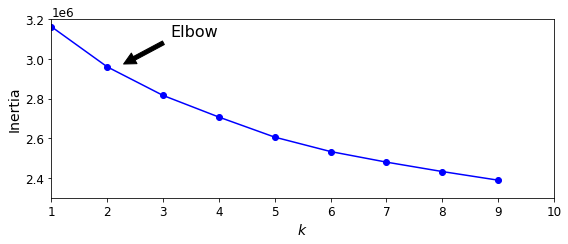

In [27]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2.2, inertias[1]),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 2300000, 3200000])
save_fig("inertia_vs_k_plot")
plt.show()

Then let's take a look at the silhouette score, which is the mean silhouette coefficient over all the instances. 

In [0]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X_train_2d, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


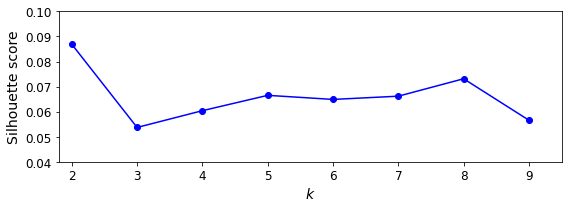

In [33]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.04, 0.10])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


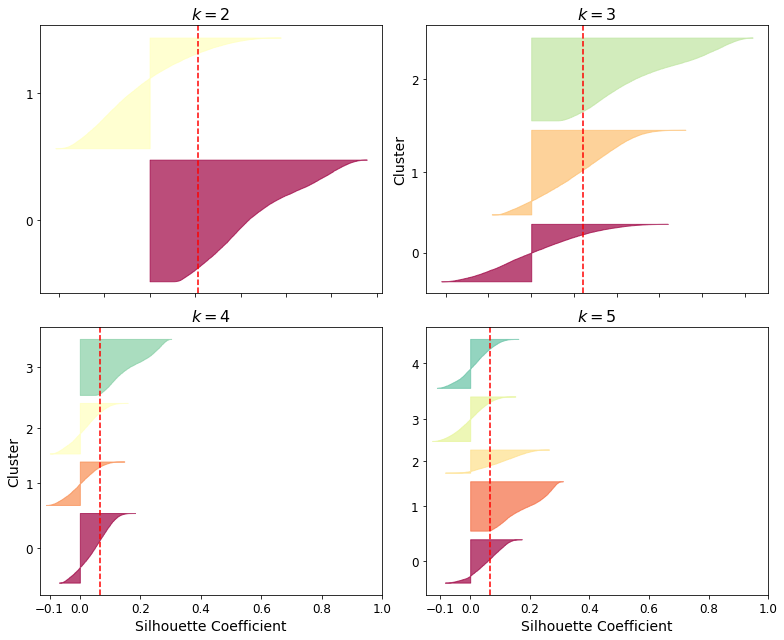

In [0]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X_train_2d, y_pred)

    padding = len(X_train_2d) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

# Train a classifier (LogisticRegression)

In [34]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)
log_reg.fit(X_train_2d, y_train)
log_reg.score(X_test_2d, y_test)

0.9198

The prediction accuracy is 91.98%. Let's see how is the performance after implementing the K-means algorithm.

In [37]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=10000, random_state=42)),
])
pipeline.fit(X_train_2d, y_train)
pipeline.score(X_test_2d, y_test)

0.9125

With cluster = 50, the accuracy doesn't show improvement, but get slice lower. Since this cluter number is arbitary. 

Here we try to find the best k, when the accuracy score peaks.

It will take over 2 days to run k-mean through 2-100.

---



In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(10, 100, 10))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train_2d, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=10, total= 1.3min
[CV] kmeans__n_clusters=10 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ............................ kmeans__n_clusters=10, total= 1.5min
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total= 1.6min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=20 ...........................................
[CV] ............................ kmeans__n_clusters=20, total= 2.5min
[CV] kmeans__n_clusters=30 ...........................................
[CV] ............................ kmeans__n_clusters=30, total= 4.3min
[CV] kmeans__n_clusters=30 ...........................................
[CV] ............................ kmeans__n_clusters=30, total= 3.9min
[CV] kmeans__n_clusters=30 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 183.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

In [39]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [40]:
grid_clf.score(X_test_2d, y_test)

0.9337

K,  from 10-90, the best value is 90, the accuracy increased from 91.98% to 93.37%

# Using K-mean Clustering as Dismension Reduction for Classification

Let's train a random forrest classifier.

In [25]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_2d, y_train)
clf.score(X_test_2d, y_test)

0.9706

Next, we'll test using K-mean (k=50) as a dimension reduction tool.

In [0]:
best_model = KMeans(n_clusters=50, random_state=42).fit(X_train_2d)
X_train_reduced = best_model.transform(X_train_2d)
X_test_reduced = best_model.transform(X_test_2d)

In [29]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_test_reduced, y_test)

0.9338

By lowing the accuracy rate 3.68%, it did work on the task of dimension reduction.

# Gaussian Mixture Model Test

First, let's perform PCA dimension reduction with 99% variance remained.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

pca.n_components_

331

The number of dimensions of the dataset is reduced from 784 to 331.

Train Gaussian Mixture Model. (Takes about one and a half hour to train.)

In [0]:
gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

In [9]:
gm.means_

array([[ 1.87634845e+00, -7.69718390e-02,  2.41839735e+00, ...,
        -2.94338046e-03, -6.78336145e-03, -8.83911348e-03],
       [-2.89208809e+00, -2.28736194e+00,  1.13482962e+00, ...,
        -4.82744222e-04,  1.58916724e-03,  3.16179482e-03],
       [-1.90696418e+00,  1.50900813e+00, -1.27334866e+00, ...,
        -1.64380581e-03, -1.70559691e-03,  1.47550515e-03],
       ...,
       [-1.92395851e+00,  1.63494619e+00,  6.68245902e-01, ...,
        -2.37581290e-03,  1.74014721e-03, -8.97832910e-04],
       [ 2.74616238e+00,  6.15993216e-01,  4.93479578e-01, ...,
        -3.36726355e-04, -2.32843381e-03, -1.11163722e-03],
       [ 3.93397453e+00, -1.32900935e+00, -1.87153898e+00, ...,
        -3.14814380e-03, -2.79850464e-03, -3.41295939e-03]])

In [10]:
gm.weights_

array([0.01388333, 0.02069999, 0.01069999, 0.01641667, 0.02043342,
       0.02670006, 0.06913372, 0.01446666, 0.02506661, 0.05225013,
       0.03706626, 0.02293271, 0.01833344, 0.03524814, 0.035234  ,
       0.01646666, 0.04385041, 0.03488388, 0.02594994, 0.01639994,
       0.02171661, 0.01628323, 0.0172499 , 0.01318333, 0.00914998,
       0.01291666, 0.03381667, 0.01481647, 0.02209962, 0.02321673,
       0.02519984, 0.0144665 , 0.04745156, 0.03116625, 0.01803352,
       0.04008334, 0.01091666, 0.04413402, 0.01148323, 0.01649993])

In [11]:
gm.covariances_

array([[[ 1.41731223e+00, -6.08982888e-02,  8.56687228e-02, ...,
          3.45770288e-03,  1.67937053e-02,  1.23966742e-02],
        [-6.08982888e-02,  6.59497030e-01,  2.48660158e-01, ...,
         -2.44091957e-04, -9.04900575e-03, -7.31086326e-03],
        [ 8.56687228e-02,  2.48660158e-01,  1.07425552e+00, ...,
         -1.69292931e-03, -3.72986260e-03, -5.46788144e-03],
        ...,
        [ 3.45770288e-03, -2.44091957e-04, -1.69292931e-03, ...,
          6.75795615e-03, -1.54889434e-04,  1.29238779e-04],
        [ 1.67937053e-02, -9.04900575e-03, -3.72986260e-03, ...,
         -1.54889434e-04,  1.04953900e-02,  2.13685591e-03],
        [ 1.23966742e-02, -7.31086326e-03, -5.46788144e-03, ...,
          1.29238779e-04,  2.13685591e-03,  1.02598221e-02]],

       [[ 1.90387726e-01,  4.27486002e-02,  1.10772627e-01, ...,
          2.29319704e-03,  6.62310075e-04, -9.68273708e-04],
        [ 4.27486002e-02,  4.00335593e-01, -9.25956821e-02, ...,
         -7.68956536e-04,  2.05633376e

In [12]:
gm.converged_

True

In [13]:
gm.n_iter_

69

Use the model to generate some new digits (inverse_transform() method is used because, PCA is performed)), and visualize them.

In [0]:
n_gen_d = 20
gen_d_reduced, y_gen_d = gm.sample(n_samples=n_gen_d)
gen_d = pca.inverse_transform(gen_d_reduced)

In [0]:
def plot_digits(digits, labels, n_cols=5):
    n_rows = (len(digits) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (digit, label) in enumerate(zip(digits, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(digit.reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()


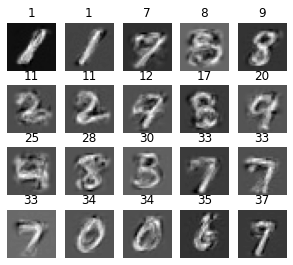

In [16]:
plot_digits(gen_d, y_gen_d)

Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

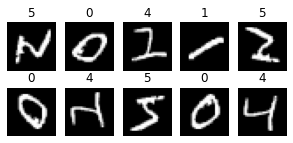

In [17]:
n_rotated = 4
rotated = np.transpose(X_train_2d[:n_rotated].reshape(-1, 28, 28), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 28*28)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train_2d[:n_flipped].reshape(-1, 28, 28)[:, ::-1]
flipped = flipped.reshape(-1, 28*28)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train_2d[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 28*28)
y_darkened = y_train[:n_darkened]

X_bad_digits = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_digits(X_bad_digits, y_bad)

In [19]:
X_bad_digits_pca = pca.transform(X_bad_digits)
gm.score_samples(X_bad_digits_pca)

array([-538.06697567,  241.8832319 ,  333.58394651,  478.97935602,
        272.73308332,    6.19373254, -507.77662145,  443.68580907,
        516.18749928,  400.03365651])

Some of the bad digits are considered unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [43]:
gm.score_samples(X_train_pca[:10])

array([ 300.85492469,  361.06825684,  313.68547705,  967.48625178,
        642.14473668,  338.50697683, 1161.76947665,  362.50587114,
       1199.30938264,  356.14961205])